# LGG vs HGG

This model's task is to accurately distinguish between low grade level glioma and high grade level glioma based on the radiomic features of a patient's MRI scans. 

 <span style="font-size:18px; font-family:Arial;">Download dependencies</span>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import product
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter





# Load the files

In [2]:
name_mapping_path = '/home/lopez1998/dev/Finals/name_mapping.csv'
filtered_radiomic_path = '/home/lopez1998/dev/Finals/filtered_radiomic_df.csv'
radiomic_feature_path = '/home/lopez1998/dev/Finals/radiomic_features.csv'

name_mapping_df = pd.read_csv(name_mapping_path)
filtered_radiomic_df = pd.read_csv(filtered_radiomic_path)
radiomic_features_df = pd.read_csv(radiomic_feature_path)


In [3]:
filtered_radiomic = radiomic_features_df[[col for col in radiomic_features_df.columns if col.startswith('original') or col == 'Image']]
filtered_radiomic['Subject_ID'] = filtered_radiomic['Image'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[:3]))
filtered_radiomic.head



/tmp/ipykernel_3453666/4174573981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_radiomic['Subject_ID'] = filtered_radiomic['Image'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[:3]))


<bound method NDFrame.head of                                                   Image  \
0     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
1     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
2     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
3     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
4     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
...                                                 ...   
1471  /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
1472  /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
1473  /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
1474  /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
1475  /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   

      original_shape_Elongation  original_shape_Flatness  \
0                      0.805396                 0.503966   
1                      0.805396                 0.503966   
2                      0.805396                 0.503966   
3                    

# remove columns from name_mapping


In [4]:
# Filter the name mapping to include only subjects from 2020 and then merge it with the radiomic features based on the 2020 subject ID
name_mapping_2020_df = name_mapping_df[['Grade', 'BraTS_2020_subject_ID']].rename(columns={'BraTS_2020_subject_ID': 'Subject_ID'})

# Merge based on Subject_ID, keeping only 2020 subjects
merged_df = pd.merge(name_mapping_2020_df, filtered_radiomic, on='Subject_ID', how='inner')

merged_df.head



<bound method NDFrame.head of      Grade            Subject_ID  \
0      HGG  BraTS20_Training_001   
1      HGG  BraTS20_Training_001   
2      HGG  BraTS20_Training_001   
3      HGG  BraTS20_Training_001   
4      HGG  BraTS20_Training_002   
...    ...                   ...   
1471   HGG  BraTS20_Training_368   
1472   HGG  BraTS20_Training_369   
1473   HGG  BraTS20_Training_369   
1474   HGG  BraTS20_Training_369   
1475   HGG  BraTS20_Training_369   

                                                  Image  \
0     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
1     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
2     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
3     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
4     /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
...                                                 ...   
1471  /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
1472  /Users/sgutta/Desktop/Brain_Tumor_Data/MICCAI_...   
1473  

# Distribution of High Grade vs Low Grade

In [5]:
grade_counts = merged_df['Grade'].value_counts()
grade_counts

Grade
HGG    1172
LGG     304
Name: count, dtype: int64

# Split data

In [6]:
# Separate features and labels
X = merged_df.drop(columns=['Grade', 'Subject_ID', 'Image'])
y = merged_df['Grade']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting splits
(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)

(((1180, 107), (296, 107)), ((1180,), (296,)))

# Random Forests

In [7]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


labels = ['HGG', 'LGG']
conf_matrix_df = pd.DataFrame(conf_matrix, 
    index=[f"Actual {label}" for label in labels],
    columns=[f"Predicted {label}" for label in labels])

print(conf_matrix_df)


print("\nClassification Report:")
print(class_report)

            Predicted HGG  Predicted LGG
Actual HGG            237              1
Actual LGG             37             21

Classification Report:
              precision    recall  f1-score   support

         HGG       0.86      1.00      0.93       238
         LGG       0.95      0.36      0.53        58

    accuracy                           0.87       296
   macro avg       0.91      0.68      0.73       296
weighted avg       0.88      0.87      0.85       296



In the sequence above each patient as multiple entries and although this is a binary classification, there are differences in the radiomic features and how each on present itself

The data will be split now into different sequences and be tested to determine which sequence contributes the most significant radiomic features

In [8]:
t1_df = merged_df[merged_df['Image'].str.contains('_t1.nii', case=False, na=False)]
t1ce_df = merged_df[merged_df['Image'].str.contains('_t1ce.nii', case=False, na=False)]
t2_df = merged_df[merged_df['Image'].str.contains('_t2.nii', case=False, na=False)]
flair_df = merged_df[merged_df['Image'].str.contains('_flair.nii', case=False, na=False)]

# Checking the number of samples in each filtered dataset to confirm 369 samples per sequence type
len_t1 = len(t1_df)
len_t1ce = len(t1ce_df)
len_t2 = len(t2_df)
len_flair = len(flair_df)

len_t1, len_t1ce, len_t2, len_flair

(369, 369, 369, 369)

# Test Each Dataframe Separately

In [9]:
results = {}
datasets = {
    "T1": t1_df,
    "T1CE": t1ce_df,
    "T2": t2_df,
    "FLAIR": flair_df
}
for sequence, df in datasets.items():
    # Keep only numeric columns for features (excluding 'Image' and 'Subject_ID')
    X = df.select_dtypes(include=['number'])  # Retain only numeric columns for model training
    y = df['Grade']  # Assuming 'Grade' is the label column

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions and evaluate the model
    y_pred = rf_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Store results
    results[sequence] = {
        "model": rf_model,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
    }

# Display structure of results for each sequence type
for sequence, result in results.items():
    print(f"Sequence: {sequence}")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\nClassification Report:")
    print(result['classification_report'])
    print("\n" + "="*50 + "\n")  # Divider for readability

Sequence: T1
Confusion Matrix:
[[55  4]
 [13  2]]

Classification Report:
              precision    recall  f1-score   support

         HGG       0.81      0.93      0.87        59
         LGG       0.33      0.13      0.19        15

    accuracy                           0.77        74
   macro avg       0.57      0.53      0.53        74
weighted avg       0.71      0.77      0.73        74



Sequence: T1CE
Confusion Matrix:
[[57  2]
 [ 8  7]]

Classification Report:
              precision    recall  f1-score   support

         HGG       0.88      0.97      0.92        59
         LGG       0.78      0.47      0.58        15

    accuracy                           0.86        74
   macro avg       0.83      0.72      0.75        74
weighted avg       0.86      0.86      0.85        74



Sequence: T2
Confusion Matrix:
[[58  1]
 [12  3]]

Classification Report:
              precision    recall  f1-score   support

         HGG       0.83      0.98      0.90        59
         

 # Create weights for sequences

In [10]:
# Define possible weights for each sequence
sequence_weight_options = {
    '_t1.nii': [0.05, 0.1, 0.15],      
    '_t1ce.nii': [0.5, 0.4, 0.3],  
    '_t2.nii': [0.05, 0.1, 0.15],      
    '_flair.nii': [0.3, 0.4, 0.5]   
}

# Generate all combinations of weights
weight_combinations = list(product(
    sequence_weight_options['_t1.nii'],
    sequence_weight_options['_t1ce.nii'],
    sequence_weight_options['_t2.nii'],
    sequence_weight_options['_flair.nii']
))

# Filter combinations to only include those where weights sum to 1
normalized_weight_combinations = [
    weights for weights in weight_combinations if sum(weights) == 1
]

# Print the resulting normalized weights
print(f"Generated {len(normalized_weight_combinations)} normalized weight combinations:")
for weights in normalized_weight_combinations:
    print(weights)

Generated 13 normalized weight combinations:
(0.05, 0.5, 0.05, 0.4)
(0.05, 0.5, 0.15, 0.3)
(0.05, 0.4, 0.05, 0.5)
(0.05, 0.4, 0.15, 0.4)
(0.05, 0.3, 0.15, 0.5)
(0.1, 0.5, 0.1, 0.3)
(0.1, 0.4, 0.1, 0.4)
(0.1, 0.3, 0.1, 0.5)
(0.15, 0.5, 0.05, 0.3)
(0.15, 0.4, 0.05, 0.4)
(0.15, 0.4, 0.15, 0.3)
(0.15, 0.3, 0.05, 0.5)
(0.15, 0.3, 0.15, 0.4)


# Train model with different sequence weights and find best results

In [11]:
# Iterate through each combination of normalized weights
results = []
for weights in normalized_weight_combinations:
    # Map weights to sequences
    sequence_weights = {
        '_t1.nii': weights[0],
        '_t1ce.nii': weights[1],
        '_t2.nii': weights[2],
        '_flair.nii': weights[3]
    }
    
    # Initialize an empty DataFrame to store weighted features
    weighted_features_list = []
    
    # Apply weights to the features
    for sequence, weight in sequence_weights.items():
        sequence_df = merged_df[merged_df['Image'].str.contains(sequence, case=False, na=False)]
        feature_columns = [col for col in sequence_df.columns if col not in ['Grade', 'Subject_ID', 'Image']]
        numeric_features = sequence_df[feature_columns].copy()
        weighted_features = numeric_features * weight
        weighted_features['Subject_ID'] = sequence_df['Subject_ID']
        weighted_features['Grade'] = sequence_df['Grade']
        weighted_features_list.append(weighted_features)
    
    # Combine weighted features into a single DataFrame
    combined_weighted_df = pd.concat(weighted_features_list)
    weighted_aggregated_df = combined_weighted_df.groupby('Subject_ID').sum().reset_index()
    weighted_aggregated_df = pd.merge(
        weighted_aggregated_df, 
        merged_df[['Subject_ID', 'Grade']].drop_duplicates(), 
        on='Subject_ID'
    )
    
    # Prepare features and labels for model training
    X = weighted_aggregated_df.drop(columns=['Grade_x', 'Subject_ID', 'Grade_y'])
    y = weighted_aggregated_df['Grade_y'].replace({'HGG': 0, 'LGG': 1})
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Calculate class weights for minority class
    class_counts = Counter(y_train)
    scale_pos_weight = class_counts[0] / class_counts[1] if class_counts[1] != 0 else 1
    
    # Train the XGBoost model with minority class weights
    xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, scale_pos_weight=scale_pos_weight)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions and evaluate the model
    y_pred = xgb_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['HGG', 'LGG'], output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the results
    results.append({
        'weights': sequence_weights,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report
    })

# Find the best-performing weight combination
best_result = max(results, key=lambda x: x['accuracy'])
print("\nBest Weight Combination:")
print(best_result['weights'])
print(f"Accuracy: {best_result['accuracy']:.2f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(
    best_result['conf_matrix'],
    index=['Actual HGG', 'Actual LGG'],
    columns=['Predicted HGG', 'Predicted LGG']
))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['HGG', 'LGG']))

# Extract metrics for the best-performing model
best_accuracy = best_result['accuracy']
f1_hgg = best_result['class_report']['HGG']['f1-score']
f1_lgg = best_result['class_report']['LGG']['f1-score']

# Define metrics for the graph
metrics = ['Accuracy', 'F1-Score (HGG)', 'F1-Score (LGG)']
values = [best_accuracy, f1_hgg, f1_lgg]



/tmp/ipykernel_3453666/810673899.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = weighted_aggregated_df['Grade_y'].replace({'HGG': 0, 'LGG': 1})
/home/lopez1998/miniconda3/envs/my_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:24:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/tmp/ipykernel_3453666/810673899.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = weighted_aggregated_df['Grade_y'].replace({'HGG': 0,


Best Weight Combination:
{'_t1.nii': 0.1, '_t1ce.nii': 0.5, '_t2.nii': 0.1, '_flair.nii': 0.3}
Accuracy: 0.95

Confusion Matrix:
            Predicted HGG  Predicted LGG
Actual HGG             58              1
Actual LGG              3             12

Classification Report:
              precision    recall  f1-score   support

         HGG       0.92      0.95      0.93        59
         LGG       0.77      0.67      0.71        15

    accuracy                           0.89        74
   macro avg       0.84      0.81      0.82        74
weighted avg       0.89      0.89      0.89        74



# Create Bar Graph

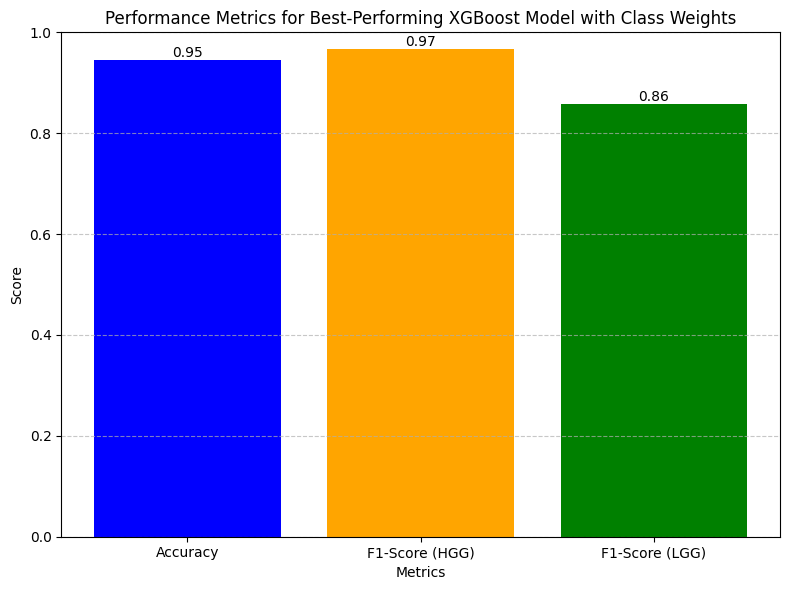

In [12]:
# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['blue', 'orange', 'green'])

# Add value labels on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.2f}', ha='center', va='bottom')

# Customize the chart
plt.ylim(0, 1)  # Limit the y-axis to [0, 1] since these are scores
plt.title('Performance Metrics for Best-Performing XGBoost Model with Class Weights')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
